In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.FCMBased.ANM.ANM import ANM
from causallearn.utils.cit import kci
from causallearn.utils.KCI.PolynomialKernel import PolynomialKernel


from dataset import EarthSystemsDataset


In [20]:
data_var_names = ['global_temp', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
y_vals = ['temp_change']
lags = 15

earth_data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=0.1, lags=lags, mode='ann')
earth_data.full_mode()
earth_data.data['index'] = list(range(earth_data.data.shape[0]))
earth_data.data

temp_change  elec_fossil  elec_clean  co2_average  ch4_average  \
year month                                                                   
1983 Jul           0.18     4.325726    0.345359       342.14      1625.94   
     Aug           0.35     4.710642    0.338025       340.62      1628.06   
     Sep           0.37     4.546845    0.315758       340.53      1638.44   
     Oct           0.17     4.699021    0.320524       341.75      1644.79   
     Nov           0.30     4.574850    0.325785       342.83      1642.60   
...                 ...          ...         ...          ...          ...   
2023 May           0.94     7.244133    0.740660       420.56      1920.00   
     Jun           1.08     7.063367    0.691709       419.57      1915.94   
     Jul           1.19     7.253938    0.711895       417.85      1914.56   
     Aug           1.19     7.397303    0.711962       416.59      1919.15   
     Sep           1.48     7.202198    0.666253       416.99      1927.35   

            index  
year month         
1983 Jul        0  
     Aug        1  
     Sep        2  
     Oct        3  
     Nov        4  
...           ...  
2023 May      478  
     Jun      479  
     Jul      480  
     Aug      481  
     Sep      482  

[483 rows x 6 columns]

In [25]:
d = earth_data.data.to_numpy()
# kci = CIT(d, 'kci', kernelZ='Gaussian')
# cg = pc(d, verbose=True)
cg = pc(d, indep_test=kci)

  0%|          | 0/6 [00:00<?, ?it/s]

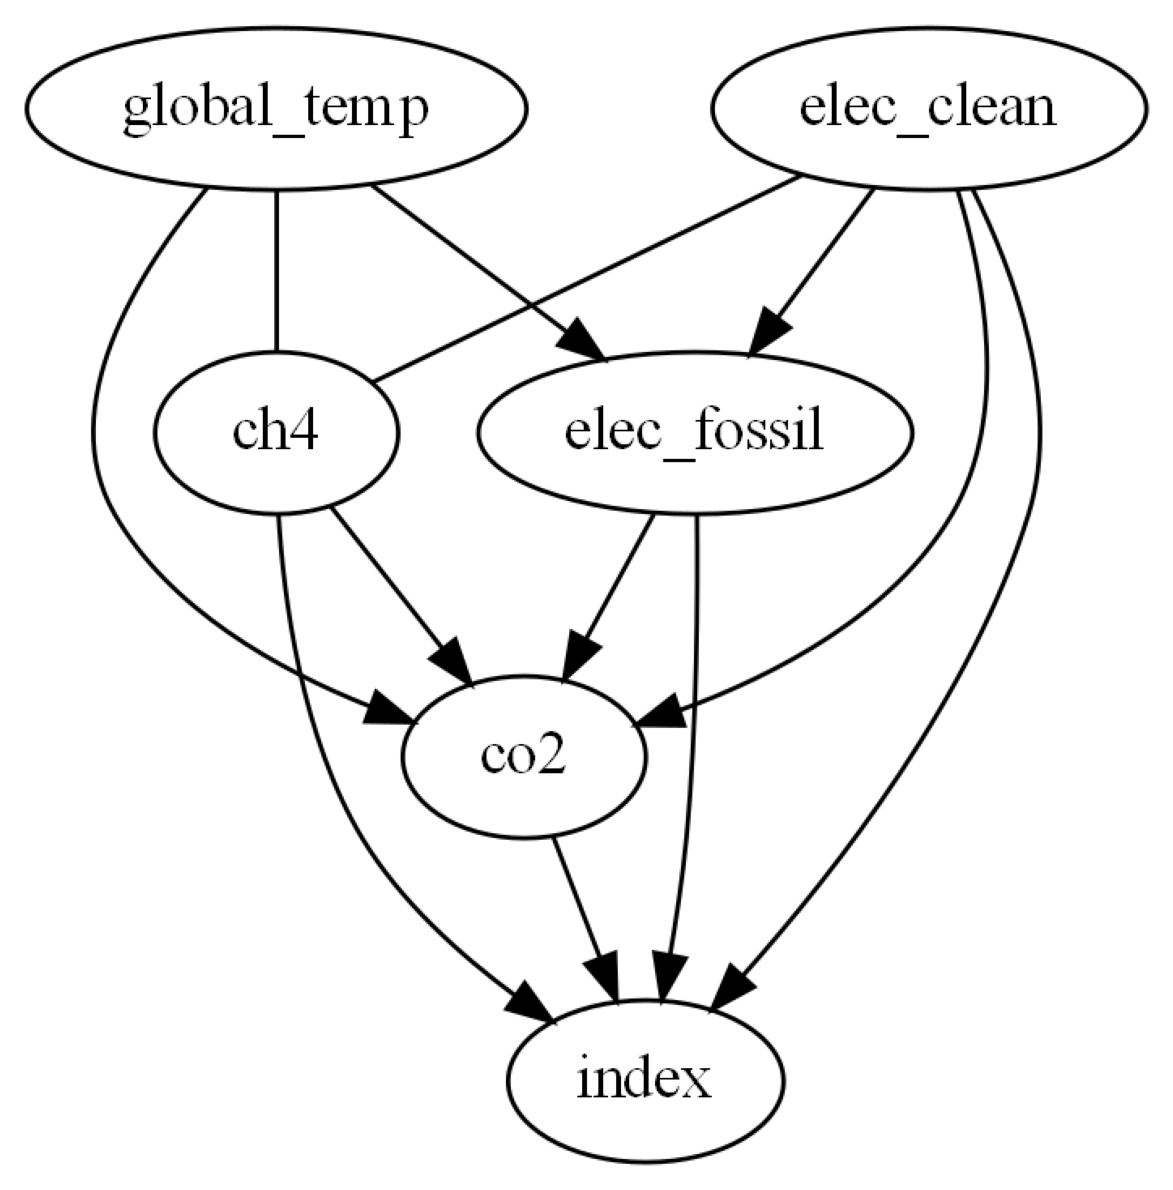

In [26]:
cg.draw_pydot_graph(labels=data_var_names+['index'])

In [23]:
cg.G.graph

array([[ 0,  0,  0, -1,  0,  0],
       [ 0,  0,  1, -1,  1, -1],
       [ 0, -1,  0, -1,  0,  0],
       [ 1,  1,  1,  0,  0, -1],
       [ 0, -1,  0,  0,  0, -1],
       [ 0,  1,  0,  1,  1,  0]])

In [24]:
for i in range(earth_data.data.shape[1]):
    for j in range(i):
        x, y = earth_data.data.iloc[:, i], earth_data.data.iloc[:, j]
        anm = ANM()
        p_xy, p_yx = anm.cause_or_effect(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))

        print(f'{earth_data.data.columns[i]} --- {earth_data.data.columns[j]}: {p_xy:.5f}, {p_yx:.5f}')

elec_fossil --- temp_change: 0.00000, 0.00000
elec_clean --- temp_change: 0.00000, 0.00000
elec_clean --- elec_fossil: 0.00000, 0.00000
co2_average --- temp_change: 0.02388, 0.00000
co2_average --- elec_fossil: 0.00000, 0.00000
co2_average --- elec_clean: 0.34678, 0.00000
ch4_average --- temp_change: 0.00336, 0.00000
ch4_average --- elec_fossil: 0.00000, 0.00000
ch4_average --- elec_clean: 0.00000, 0.00000
ch4_average --- co2_average: 0.00000, 0.00000
index --- temp_change: 0.82900, 0.00000
index --- elec_fossil: 0.00000, 0.00000
index --- elec_clean: 0.02000, 0.00000
index --- co2_average: 0.89106, 0.00023
index --- ch4_average: 0.47884, 0.00000


In [13]:
from scipy.stats import linregress

x, y = earth_data.data['elec_fossil'], earth_data.data['co2_average']
anm = ANM()
p_xy, p_yx = anm.cause_or_effect(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))

In [14]:
p_xy, p_yx

(0.0, 3.219646771412954e-15)

### Manual verification that CO2 affects global_temp

Text(0.5, 1.0, 'Residuals of y --> x')

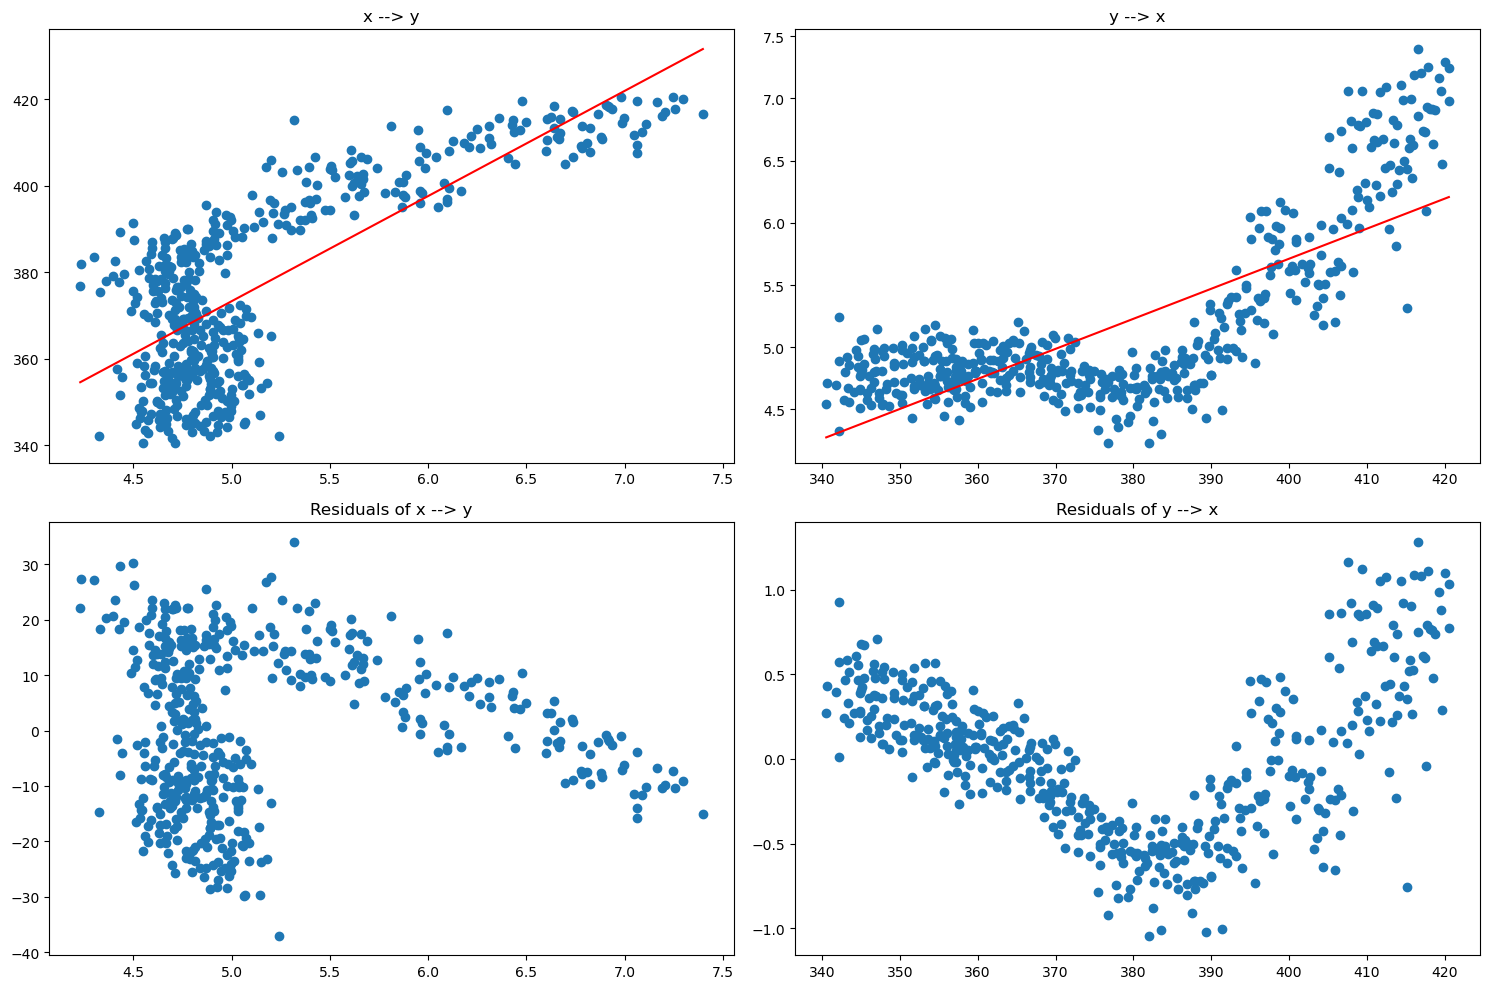

In [15]:
# testing causal relationship in x --> y
reg_xy = linregress(x,y)
m_xy, b_xy = reg_xy.slope, reg_xy.intercept

# testing causal relationship in y --> x
reg_yx = linregress(y,x)
m_yx, b_yx = reg_yx.slope, reg_yx.intercept


t_xy = np.linspace(x.min(), x.max(), 2500)
t_yx = np.linspace(y.min(), y.max(), 2500)

# Plot lines of best fit and residuals
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Plot points and regression line for x --> y
axes[0,0].scatter(x,y)
axes[0,0].plot(t_xy, m_xy*t_xy + b_xy, color='red')
axes[0,0].set_title('x --> y')

# Plot points and regression line for y --> x
axes[0,1].scatter(y,x)
axes[0,1].plot(t_yx, m_yx*t_yx + b_yx, color='red')
axes[0,1].set_title('y --> x')

# Plot residuals for x --> y
axes[1,0].scatter(x, y - (m_xy*x + b_xy))
axes[1,0].set_title('Residuals of x --> y')

# Plot residuals for y --> x
axes[1,1].scatter(y, x - (m_yx*y + b_yx))
axes[1,1].set_title('Residuals of y --> x')


It looks like y is coordinated with the residuals predicting y --> x, so we conclude that y --> x is true.

(is this interpretation right?)

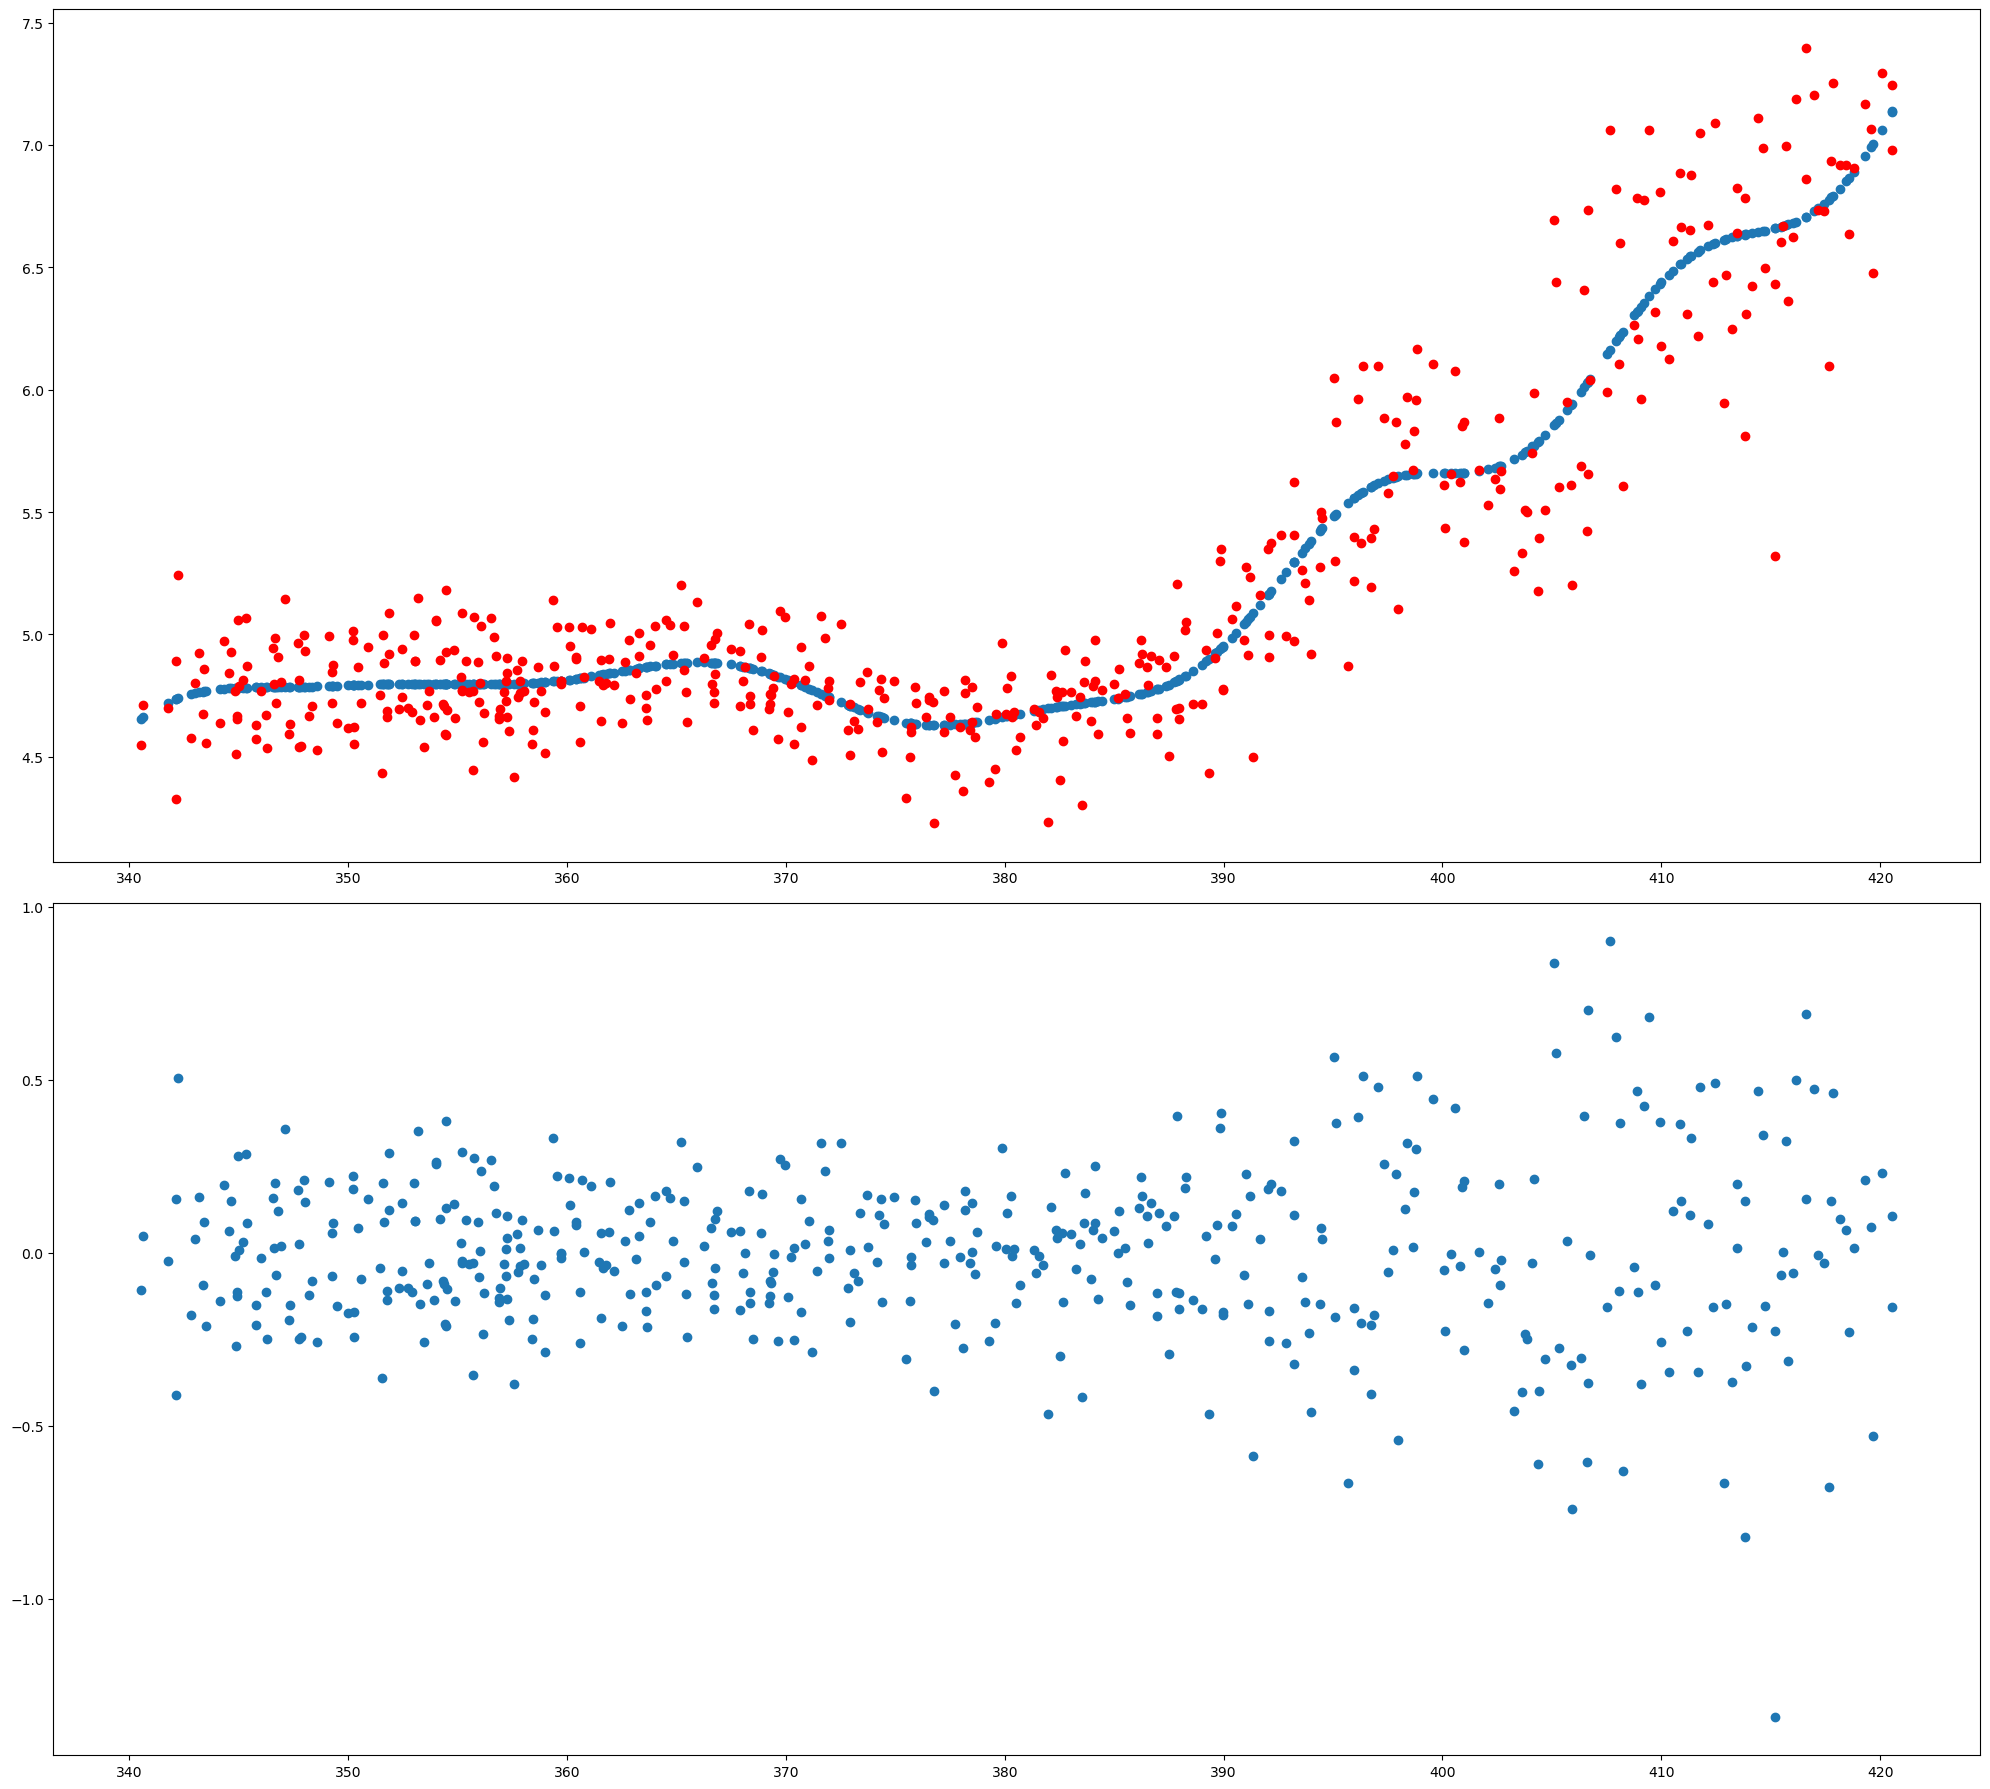

In [16]:
anm = ANM()
y, x = earth_data.data['elec_fossil'], earth_data.data['co2_average']
pred_y = anm.fit_gp(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))

fig, axes = plt.subplots(2, 1, figsize=(20,18))
axes[0].scatter(x, pred_y)
axes[0].scatter(x, y, color='red')

axes[1].scatter(x, y - pred_y.flatten())

In [11]:
from causallearn.utils.KCI.KCI import KCI_UInd
kci = KCI_UInd(kernelX='Gaussian', kernelY='Gaussian')

kci.compute_pvalue(x.to_numpy().reshape(-1,1), (y - pred_y.flatten()).to_numpy().reshape(-1,1))

(4.92915114946868e-07, 778.7558428129257)

(array([19., 51., 85., 85., 91., 80., 50., 15.,  4.,  3.]),
 array([-0.04 ,  0.112,  0.264,  0.416,  0.568,  0.72 ,  0.872,  1.024,
         1.176,  1.328,  1.48 ]),
 <BarContainer object of 10 artists>)

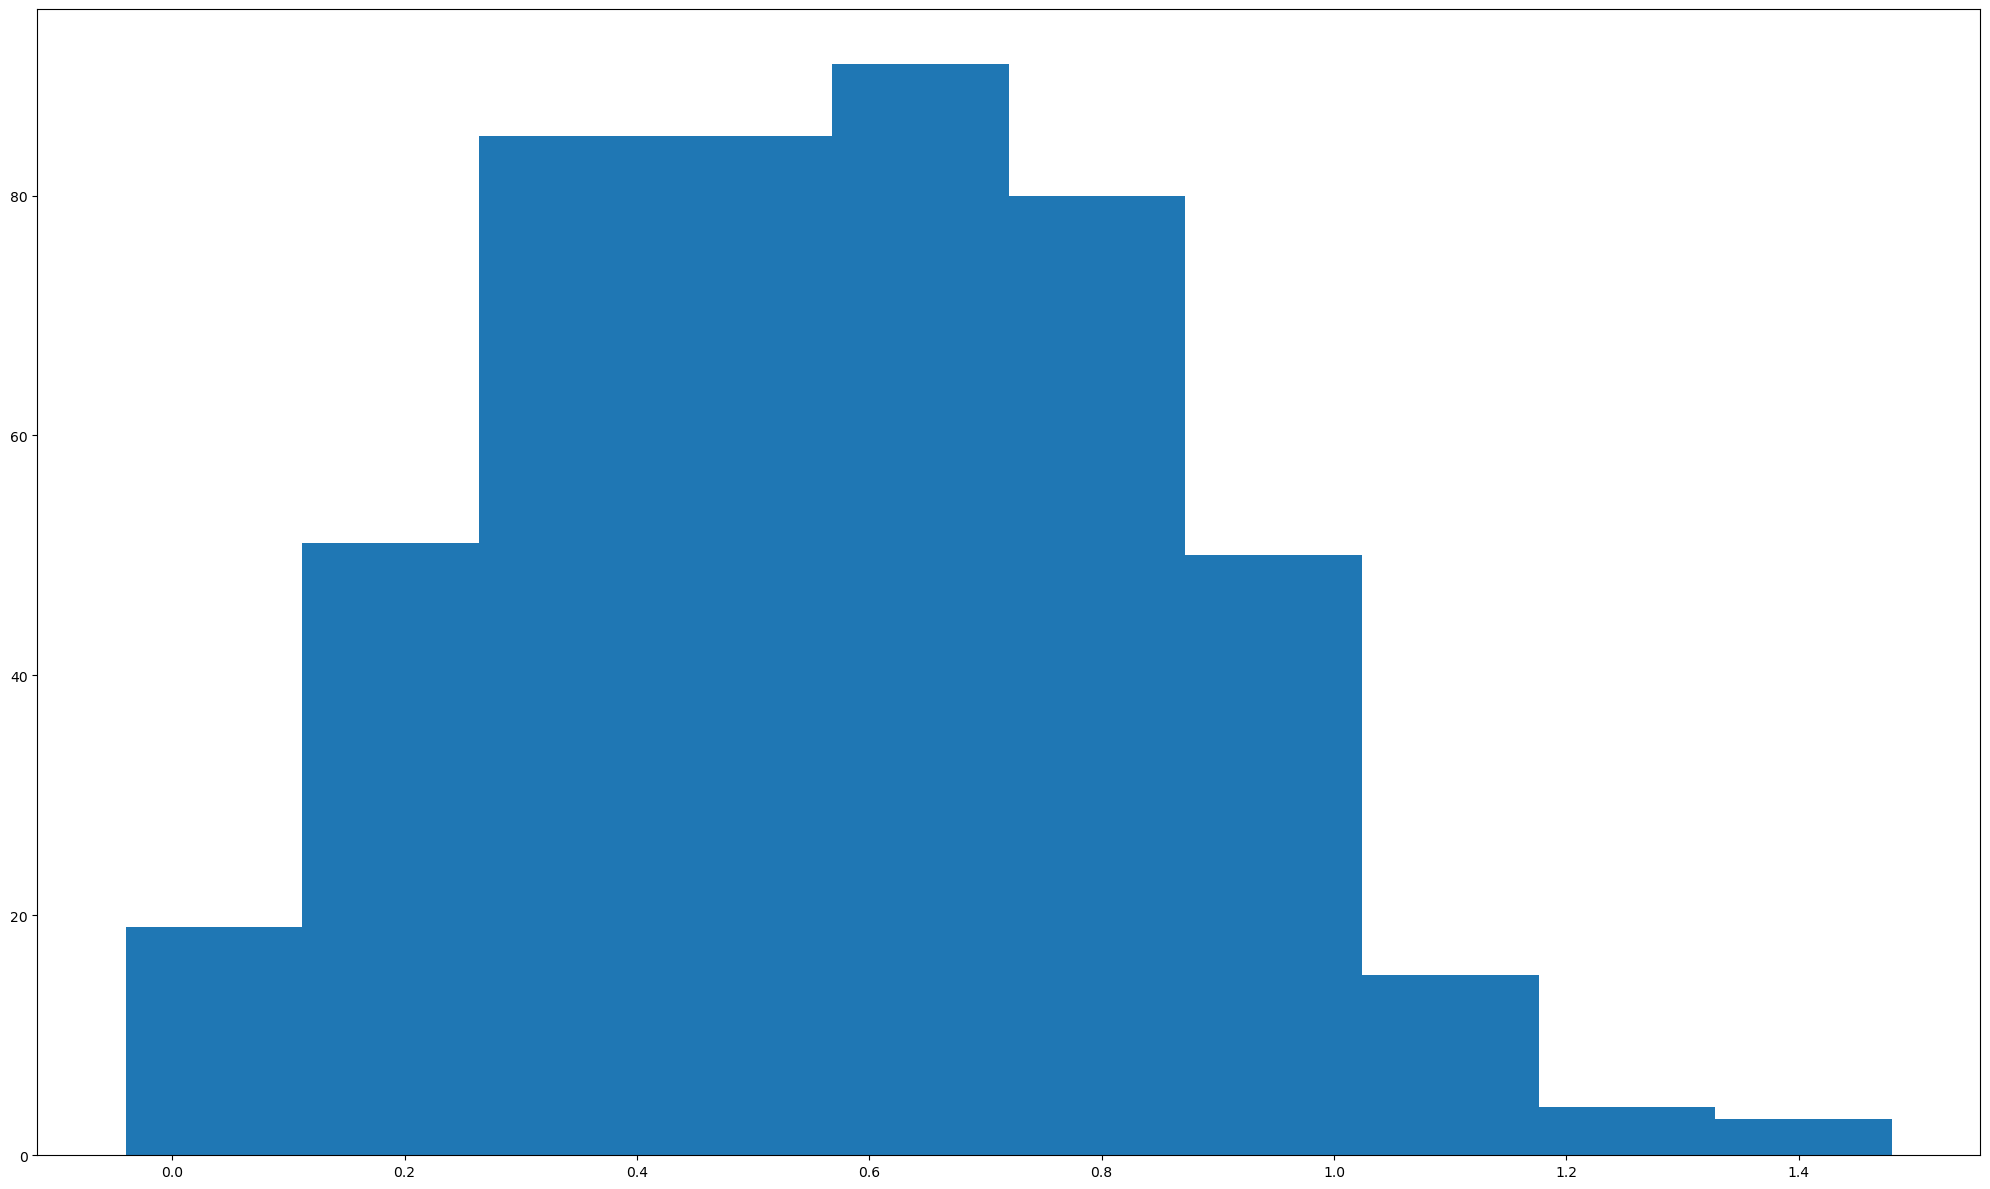

In [12]:
# plt.hist(y - pred_y.flatten())
plt.hist(x)